In [1]:
# CSS style setting
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
colors = ['#064572', '#A8854F', '#7E98B2', '#663DB8', '#2D795E', '#57073E', '#AF550B', '#15042E', '#DD1E6A', '#CB9F07', '#44143B', '#0BAFA1']


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:118%; text-align:left">

<h3 align="left"><font color='#05041B'>💡🧠Overview :</font></h3>
    
    
* Implementaré el los modelos CastBoost & Random Forest en mi base de datos de 1800 leads provenientes de mi consultoría de franquicias, seleccionando 22 de 150 atributos por lead. 
* A pesar de imperfecciones en los datos y su extracción desde **Hubspot**, mi meta es optimizar la eficiencia del consultor y atender oportunamente las oportunidades con mínimo impacto.
* Notebook in English https://www.kaggle.com/code/ivancanepa/optimization-hubspot-lead-mgmt-catboost-rf

<p style="text-align:left;">
<img src="https://github.com/santiagocanepa/Optimizing-the-Management-of-1800-Own-Leads-in-HubSpot-Applying-XGB-CatBoost-and-Random-Forest/blob/main/imag/pngwing.com.png?raw=true" width="13.8%" height="30%">

<p style="text-align:left;">
    <img src="https://github.com/santiagocanepa/Optimizing-the-Management-of-1800-Own-Leads-in-HubSpot-Applying-XGB-CatBoost-and-Random-Forest/blob/main/imag/FQC_Logo_2@2x.png?raw=true" width="15%" height="30%">

### </p> <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📚Step 1: Importing Libraries and Modules

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import scikitplot as skplt
import scipy.stats as ss
import seaborn as sns
import os
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from plotly.subplots import make_subplots
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 



### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">🔎 Step 2: Data Loading and Exploration</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
* Carga de data (csv copy-paste de hubspot)
* Analisis y transformación prelimiar
* Limpieza y entrada de campos vacios
    

In [4]:
df = pd.read_excel("/kaggle/input/copy-leads-fqc-hubspot/copy_leads_FQC_hubspot.xlsx")

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Nombre                  5206 non-null   object 
 1   Apellido                1801 non-null   object 
 2   Pais                    1801 non-null   object 
 3   Zona Horaria            1801 non-null   object 
 4   Provincia               1801 non-null   object 
 5   Localidad               1801 non-null   object 
 6   Zona                    1801 non-null   object 
 7   Ciudad IP               1801 non-null   object 
 8   Estado actual del lead  1801 non-null   object 
 9   Fuente                  1801 non-null   object 
 10  Fuente Ultima           1702 non-null   object 
 11  Fuente Original         1801 non-null   object 
 12  Mensaje                 1801 non-null   object 
 13  Comentario              1801 non-null   object 
 14  formularios enviados    1801 non-null   

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Es nesesario limpiar la data que nos dio hubspot, primero eliminaremos las filas que contienen las iniciales y  "vista previa" en la columnna Nombre.

* Ademas, eliminamos todos los campos NaN debido a que el campo vacio por defecto en hubspot es "--".

* Ademas, modificamos los tipos de datos y convertimos los valores str en minuscula y los numericos en float.
    
* La columna "estado actual del lead" sera nuestra columna objetivo y la renombrambos "v_target"

In [5]:
# df = df[(df['Nombre'].str.len() > 2) & (df['Nombre'] != 'Vista previa') ]

df = df.dropna(subset=['Nombre', 'Apellido'])
df = df.astype(str)
df = df.applymap(lambda s:s.lower().strip() if type(s) == str else s)

columnas_int = ['Visitas a la pagina', 'formularios enviados', 'Interacciones varias', 'Aperturas de correo']

for columna in columnas_int:
    df[columna] = df[columna].astype(float)  
    
# Elimino las columnas que no aportan al modelo ni al analisis.
df = df.drop(['Nombre','Apellido','correo','Mensaje','Comentario', 'numero ', 'Zona Horaria', 'Pais'], axis=1)

# Convertir todas las etiquetas de las columnas a minúsculas y eliminar los espacios en blanco al principio y al final
df.columns = df.columns.str.lower().str.strip()

# Renombrar la columna 'elead' a 'v_target'
df = df.rename(columns={'estado actual del lead': 'v_target'})



In [6]:
print('Variables Categoricas')
df.describe(include='object').head(2)

Variables Categoricas


,provincia,localidad,zona,ciudad ip,v_target,fuente,fuente ultima,fuente original,franquicia,inversion
count,1797,1797,1797,1797,1797,1797,1797,1797,1797,1797
unique,19,321,151,192,13,14,9,8,111,2


In [7]:
print("Variables Numericas")
df.describe().head(6)

Variables Numericas


,formularios enviados,visitas a la pagina,interacciones varias,aperturas de correo
count,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.824151,0.818587,0.956594,0.629382
std,0.744853,0.814970,2.025810,1.003104
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* Ahora, intentare clasificar, transformar y reducir al maximo las columnas predictoras.

In [8]:
cant_distintos = df.agg(pd.Series.nunique)
valores_unicos = {col: df[col].unique() for col in df.columns}
print("Cantidad de valores distintos en cada columna:")
print(cant_distintos)

Cantidad de valores distintos en cada columna:
provincia                19
localidad               321
zona                    151
ciudad ip               192
v_target                 13
fuente                   14
fuente ultima             9
fuente original           8
formularios enviados      8
visitas a la pagina       7
interacciones varias     15
aperturas de correo       8
franquicia              111
inversion                 2
dtype: int64


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📋 Step 3: Data Preprocessing | Variables predictoras & Variable Objetivo</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:112%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font> 📍 Ubicacion del Lead </h3>  
   
* 🖇️ Variables Predictoras: **"Provincia, Localidad, Zona, Ciudad IP"**.
* 🖇️ Variables Predictora Unificada en: **"zone"**
* Debido a los campos vacíos, el objetivo es consolidar la información en 1 columna que llamaremos "zone"
* A priori, la variable de **ubicación** de un prospecto es relevante; no obstante, la data esta muy sucia y analizaremos su incorporacion al modelo y bajo que terminos.

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# Definir las columnas categóricas
cat_columns = ['provincia', 'localidad', 'zona', 'ciudad ip']
# Calcular filas y columnas para subplot
n_cols = 2
n_rows = math.ceil(len(cat_columns) / n_cols)
# Crear subplot
fig = make_subplots(rows=n_rows, cols=n_cols)
# Añadir gráficos de barras para cada variable categórica
for i, col in enumerate(cat_columns):
    curr_row = i // n_cols + 1
    curr_col = i % n_cols + 1
    # Seleccionar los 6 valores más comunes
    top_values = df[col].value_counts().head(6)   
    fig.add_trace(go.Bar(
        x=top_values.index,
        y=top_values.values,
        name=col,
        text=top_values.values,
        textposition='auto',
        marker_color=colors[i % len(colors)]
    ), row=curr_row, col=curr_col)
# Actualizar layout
fig.update_layout(
    title_text='Distribución de las 6 categorías más comunes para cada variable',
    height=300 * n_rows,  
    showlegend=False,
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Mayoria **"--"** **(Campos vacios)**
* Intentare seleccionar el primer valor válido (si hubiere) de cada fila en las columnas, definiendo las prioridades de general a particular(Provincia a Localidad), 
* Unificando las columnas respectivas a la ubicacion en la nueva columna **"zone"** y dejar los entrys sin valor en la columna **"sin valor"**

In [10]:
def seleccionar_valor(row, columnas):
    for col in columnas:
        valor = row[col]
        if not pd.isna(valor) and str(valor) != 'nan' and str(valor) != '--':
            return valor
    return 'sin valor'
columnas = ['provincia', 'zona', 'ciudad ip', 'localidad']
df['zone'] = df.apply(lambda row: seleccionar_valor(row, columnas), axis=1)
top_20_zonas = df['zone'].value_counts().head(20)
fig_bar = px.bar(x=top_20_zonas.index, y=top_20_zonas, labels={'x': 'Zonas', 'y': 'Frecuencia'}, title='Top 20 zonas más frecuentes en zone', color_discrete_sequence=colors)
fig_bar.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Unificando los nombres de las zonas Cuando contengan terminos pertinentes a Provincias que suelen aparecer repetidas.


In [11]:
def unificar_nombre_zona(zone):
    if isinstance(zone , str):
        if any(substring in zone for substring in ['aires', 'buenos', 'caba', 'capital federal', 'la matanza', 'san justo', 'quilmes', 'san martin']):
            return 'buenos aires'
        elif 'santa ' in zone or 'rosario' in zone.lower():
            return 'santa fe'
        elif 'posadas' in zone.lower():
            return 'mendoza'
        else:
            return zone
    else:
        return zone
# Aplicando a cada valor de la columna 'zonas_unificadas'
df['zone'] = df['zone'].apply(unificar_nombre_zona)
# Eliminando el resto de columnas pertinentes a este area
df = df.drop(['provincia', 'zona', 'ciudad ip', 'localidad'], axis=1)
# Verificar el resultado
zf = df['zone'].value_counts().head(18)
fig_pie = px.pie(values=zf, names=zf.index, title="Zonas Top 18", color_discrete_sequence=colors)
fig_pie.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Exeptuando Buenos Aires, el resto de Provincias no contienen valores suficientes para aportar al modelo. 
* Considerando la relevancia de otras columnas en el conjunto de datos prefiero evitar sesgar al modelo inecesariamente, por lo cual dividire a zona_unificada en 3 valores.


In [12]:
top_3_zonas = df['zone'].value_counts().head(2).index
def agrupar_otras(valores, top3_zonas):
    if valores not in top3_zonas:
        return "zonas menos recurrentes"
    else:
        return valores
df['zone'] = df['zone'].apply(lambda x: agrupar_otras(x, top_3_zonas))
# Verificar el resultado
zf = df['zone'].value_counts()
fig_pie = px.pie(values=zf, names=zf.index, title="Resultado Final en zone", color_discrete_sequence=colors)
fig_pie.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Considero concluida la variable de ubicacion geografica en zona_unificada
* Mas adelante verificare la relacion frente a otras columnas y fundamentalmente frente a la columna objetivo

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:112%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🌐 Fuente del lead </h3>  
   
* 🖇️ Variables Predictoras: **"fuente original", "fuente ultima", "fuente"**
* 🖇️ Variables Predictora Unificada: **"source"**
* Nuevamente, unificaremos los valores y en este caso, reducir e incluso identificar y renombrar los ""--"" sera mucho mas facil


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# Columnas categóricas
fue_columns = ['fuente', 'fuente original', 'fuente ultima']
# Filas y columnas para subplot
n_cols = 2
n_rows = math.ceil(len(fue_columns) / n_cols)
# Crear subplot para cada variable categórica
fig = make_subplots(rows=n_rows, cols=n_cols)
for i, col in enumerate(fue_columns):
    curr_row = i // n_cols + 1
    curr_col = i % n_cols + 1
    top_values = df[col].value_counts().head(6)
    fig.add_trace(go.Bar(
        x=top_values.index,
        y=top_values.values,
        name=col,
        text=top_values.values,
        textposition='auto',
        marker_color=colors[i % len(colors)]
    ), row=curr_row, col=curr_col)  
    fig.update_yaxes(title_text=col, row=curr_row, col=curr_col) #Asigno nombre de columna a titulo de etiqueta y
fig.update_layout(
    title_text='Distribución de las 6 categorías más comunes para cada variable de Fuente',
    height=300 * n_rows,  # Reducir la altura aquí para eliminar el espacio en blanco
    showlegend=False,
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:112%; text-align:left">
    
* Seleccionar **"Fuente"** de prioridad buscando resolver las fuentes sin conexion dado que **"--"** encontra remplazos en las variables predictoras **"fuente original"** y **"fuente ultima"**

In [14]:
def seleccionar_valor(row, columnas):
    for col in columnas:
        valor = row[col]
        if not pd.isna(valor) and str(valor) != 'nan' and str(valor) != '--':
            return valor

columnas = ['fuente original', 'fuente ultima', 'fuente']
df['source'] = df.apply(lambda row: seleccionar_valor(row, columnas), axis=1)

# Verificar el resultado
print(df['source'].head())

0       fuentes sin conexión
2           búsqueda de pago
5          búsqueda orgánica
8     redes sociales de pago
11      fuentes sin conexión
Name: source, dtype: object


In [15]:
top_10fuentes = df['source'].value_counts().head(10)
import plotly.graph_objects as go
import plotly.express as px
fig_bar = px.bar(x=top_10fuentes.index, y=top_10fuentes, labels={'x': 'source', 'y': 'Frecuencia'}, title='Resultado en source', color_discrete_sequence=colors)
fig_bar.show()

In [16]:
# Elimino las columnas excedentes relacionadas a la fuente 
df = df.drop(['fuente original', 'fuente ultima', 'fuente'], axis=1)


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:112%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>💵Inversion (Ticket) </h3>  

* 🖇️Variable Predictora 
    
* La columna Inversion decidi dejarla a pesar de contener valores vacios, ya que puedo completarlos utilizando como referencia la columna **"Franquicia"**




In [17]:
usd25mil = ['befruit', 'dulce hora', 'don antonio', 'central de pizzas y empanadas', 'big pizza']
usd60mil = ['pirka', 'guapaletas', 'don us company', 'quecrecen ar','le panem','vitalcer ', 'neo zoo', 'sanduba', 'el mundo del mueble', 'depi4ever', 'by papa', 'ferreterías h30', 'alma rural', 'all in express']
usd125mil = ['tienda de cafe', 'cafe martinez', 'cremolatti']
usd250mil = ['tostado', 'la birra bar', 'atalaya']


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
    
* Por supuesto, mantenemos la columna Monto de inversion como categorica, las numericas actuales corresponden a formas de interaccion, por lo cual podemos apreciar cierto orden en la clasificacion por escala.

In [18]:

def asignar_inversion(franquicia):
    for f in franquicia.split(","): 
        f = f.strip() 
        if f in usd25mil:
            return 'low'
        elif f in usd60mil:
            return 'med'
        elif f in usd125mil:
            return 'high'
        elif f in usd250mil:
            return 'veryhigh'
    return 'Otro'
df['inversion'] = df['franquicia'].apply(asignar_inversion)
print(df.head())

                v_target  formularios enviados  visitas a la pagina  \
0   capital insuficiente                   0.0                  0.0   
2       no va a invertir                   1.0                  1.0   
5   capital insuficiente                   1.0                  1.0   
8           mala calidad                   1.0                  1.0   
11      no va a invertir                   0.0                  0.0   

    interacciones varias  aperturas de correo      franquicia inversion  \
0                    0.0                  0.0      guapaletas       med   
2                    1.0                  1.0    la birra bar  veryhigh   
5                    0.0                  0.0  don us company       med   
8                    0.0                  0.0      guapaletas       med   
11                   6.0                  2.0      alma rural       med   

                       zone                  source  
0              buenos aires    fuentes sin conexión  
2             

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:107%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🏢 Franquicia de interes</h3>  
 
* 🖇️Variable Predictora franquicia
    
* Encontramos las 25 Franquicias que mas aparecen


In [19]:
df['franquicia'] = df['franquicia'].str.split(',').str[0]
conteo = df['franquicia'].value_counts().head(35)
fig_bar = px.bar(x=conteo.index, y=conteo, labels={'x': 'franquicias', 'y': 'Cantidad de leads recibidos'}, title=' Leads recibido x Franquicias', color_discrete_sequence=colors)
fig_bar.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left"> 
    
* Para simplificar las categorias, probe diversos umbrales y defini la mejor relación posible:

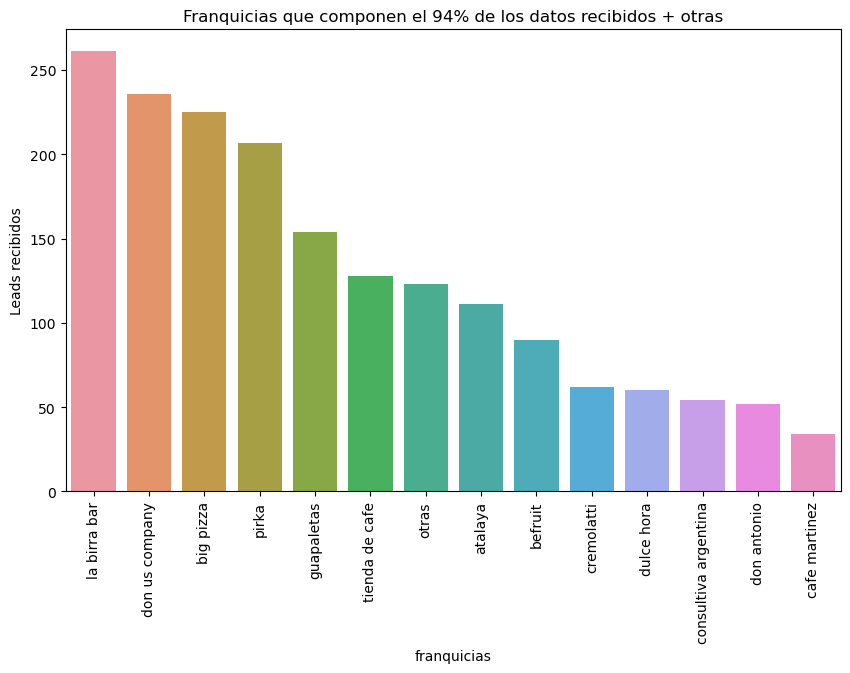

In [20]:
conteos = df['franquicia'].value_counts()
porcentaje_acumulado = conteos.cumsum() / conteos.sum()
umbral = porcentaje_acumulado[porcentaje_acumulado <= 0.94].shape[0]
# Encontrar las franquicias más comunes
franquicias_mas_comunes = conteos.index[:umbral]
# Reemplazar las franquicias que no están en las más comunes por 'Otras'
df['franquicia'] = df['franquicia'].where(df['franquicia'].isin(franquicias_mas_comunes), 'otras')
conteos = df['franquicia'].value_counts()
# Comprobar resultado 
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=conteos.index, y=conteos.values, ax=ax)
ax.set_title('Franquicias que componen el 94% de los datos recibidos + otras')
ax.set_xlabel('franquicias')
ax.set_ylabel('Leads recibidos')
plt.xticks(rotation=90)
plt.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left"> 
    
* El 94% de las categorias en la columna estan concentradas en estas Franquicias, seran las utilizadas para el modelo y las demas las dejare en **'otras'**

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:112%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🔢 Variables Discretas/Continuas</h3>  
   
* 🖇️ Variables Predictoras:
+ **'formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo'**

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Estas columnas seran las unicas incorporadas al modelo como numericas
* Miden diversas interacciones y pueden ser muy utiles para los modelos que categorizan en funcion del orden natural de sus columnas numericas.
* Primero certifico que no existan relaciones muy elevadas entre las columnas

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# Definir las columnas numéricas
num_columns = ['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']
# Calcular filas y columnas para subplot
n_cols = 2
n_rows = math.ceil(len(num_columns) / n_cols)
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=num_columns)
# Histogramas para cada variable numérica
for i, col in enumerate(num_columns):
    curr_row = i // n_cols + 1
    curr_col = i % n_cols + 1
    fig.add_trace(go.Histogram(
        x=df[col],
        name=col,
        marker_color='rgb(55, 83, 109)',
        nbinsx=50  # Ajustar el número de bins
    ), row=curr_row, col=curr_col)
    # Título y etiquetas de ejes
    fig.update_xaxes(title_text=col, row=curr_row, col=curr_col)
    fig.update_yaxes(title_text="Frecuencia", row=curr_row, col=curr_col)
# Actualizar layout
fig.update_layout(
    title_text='Distribución de las variables numéricas',
    height=300 * n_rows,  # Reducir la altura aquí para eliminar el espacio en blanco
    showlegend=False,
    bargap=0.15, 
    bargroupgap=0.1
)
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">
    
* Calculamos la matriz de correlación


<Axes: >

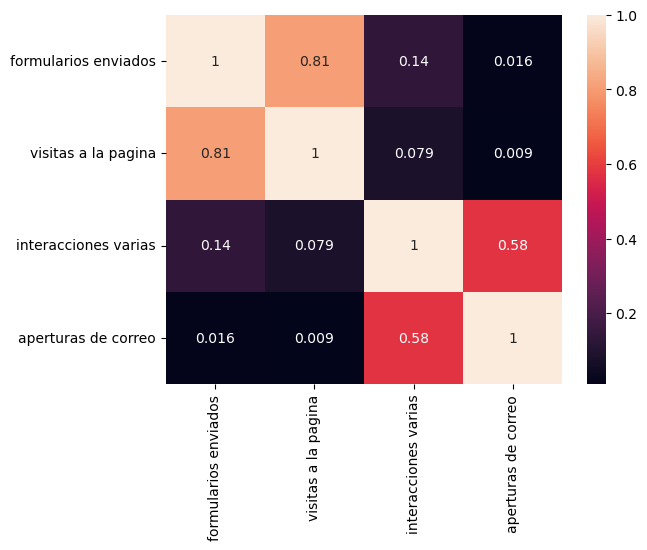

In [22]:
correlation_matrix = df[['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']].corr()
sns.heatmap(correlation_matrix, annot=True)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* Visitas a la pagina es una instancia previa en el embudo de ventas y tiene una correlacion significativa con envios de formularios.

* A pesar de las similitudes son instancias diferentes y considero relevante diferenciarlas en el modelo.

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800"></p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:100%; text-align:left">
    
<h3 align="left"><font color='#05041B'>
</font>🧪 Variable Objetivo (Estado actual del lead : "v_target")</h3>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

*  Debido a que una cantidad mayor de clases en la columna objetivo puede requerir mayor dificultad al entrenar cualquier modelo y sobre todo una gran cantidad de datos
*  La columna objetivo sera de clase binaria, agrupadas de la siguiente manera:
*  Primero, contamos la cantidad de valores únicos en columna 'v_target'

In [23]:
eleadcount = df['v_target'].value_counts().head(20)
fig_bar = px.bar(x=eleadcount.index, y=eleadcount, labels={'x': 'v_target', 'y': 'Frecuencia'}, title='Distribucion de valores Variable Objetivo (v_target)', color_discrete_sequence=colors)
fig_bar.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">


* Preparando la data para el modelo, en **v_target** defino las clases en en binarias separando ambas en **"opportunity_lead"** y **"unqualified_lead    "**


In [24]:
def crear_clase_binaria (valor):  
    opportunity_lead = ['en seguimiento', 'calificado para la compra', 'clientes']
    unqualified_lead = ['capital insuficiente', 'mala calidad', 'imposible de contactar','no solicito información', 'aun sin respuesta', 'intentando contacto', 'no va a invertir', 'crowdfunding', 'formulario', 'remarketing']   
    if valor in opportunity_lead:
        return 'opportunity_lead'
    elif valor in  unqualified_lead:
        return 'unqualified_lead'
    else:
        return np.nan
    
    if valor in opportunity_lead:
        return 'opportunity_lead'
    elif valor in  unqualified_lead:
        return 'unqualified_lead'
    else:
        return np.nan
df['v_target'] = df['v_target'].apply(crear_clase_binaria)
df = df.dropna(subset=['v_target'])
print ('v_target en clases binarias, a usar en el modelo ')
print (df['v_target'].value_counts())

v_target en clases binarias, a usar en el modelo 
unqualified_lead    1577
opportunity_lead     198
Name: v_target, dtype: int64


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* La diferencia entre los valores de cada clase es muy alta, es propio del negocio y el tipo de venta y puede ser un desafio en el modelo de predicción.
* Utilizare SMOTE como tecnica de sobremuestreo de la clase inferior para evitar desequilibrios

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">🔬 Step 4 Data Definition</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:100%; text-align:left">

* Relacion entre **Variables Predictoras** y **Variable Target**

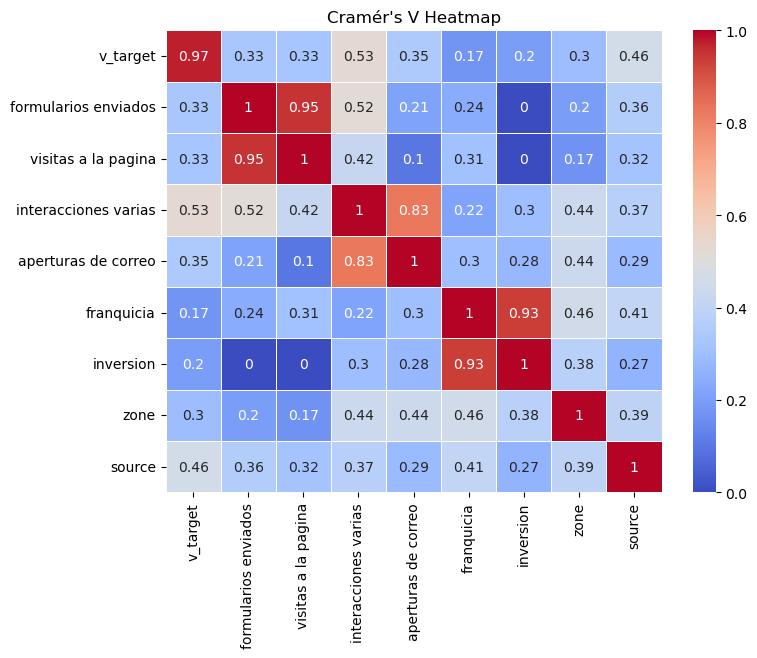

In [25]:
# Cramers_V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
columns_of_interest = ['v_target','formularios enviados', 'visitas a la pagina', 'interacciones varias', 'aperturas de correo', 'franquicia', 'inversion', 'zone', 'source']
df_selected = df[columns_of_interest]
df_sample = df_selected.sample(frac=0.1, random_state=31)
cramers_v_matrix = pd.DataFrame(index=columns_of_interest, columns=columns_of_interest)
for col1 in columns_of_interest:
    for col2 in columns_of_interest:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df_sample[col1], df_sample[col2])
cramers_v_matrix = cramers_v_matrix.astype(float)
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Cramér's V Heatmap")
plt.show()

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* Es interesante notar que interacciones varias y fuente_unificada tienen una relacion considerablemente alta con la columna objetivo


In [26]:
fig = go.Figure()
zonas_agrupadas = df.groupby(['v_target', 'source']).size().reset_index(name='conteo')
# Obtener los valores únicos de 'v_target'
unique_targets = zonas_agrupadas['v_target'].unique()
# Crear un diccionario de colores que asigna cada valor único a un color
color_dict = {val: colors[i%len(colors)] for i, val in enumerate(unique_targets)}
# Añadir una traza de barras para cada valor único
for elead in unique_targets:
    zonas_elead = zonas_agrupadas[zonas_agrupadas['v_target'] == elead]
    # Asignar el color correcto a la traza
    fig.add_trace(go.Bar(x=zonas_elead['source'], y=zonas_elead['conteo'], name=str(elead), 
                         marker_color=color_dict[elead]))  # Usar el color correspondiente del diccionario
# diseño
fig.update_layout(barmode='stack', title='Relacion entre Source y Target',
                  xaxis_title='Fuente', yaxis_title='Cantidad de v_target')
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:105%; text-align:left">

* Lo mismo en las columnas numericas: 

In [27]:
df_avg = df.groupby('v_target')['visitas a la pagina', 'interacciones varias'].mean().reset_index()
fig = px.scatter(df_avg, x="interacciones varias", y="visitas a la pagina",
	         size="interacciones varias", color="v_target",
                 hover_name="v_target", log_x=True, size_max=60)
fig.show()

/tmp/ipykernel_21/3725266836.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [28]:
df_avg = df.groupby('v_target')['visitas a la pagina', 'aperturas de correo'].mean().reset_index()
fig = px.scatter(df_avg, x="visitas a la pagina", y="aperturas de correo",
	         size="aperturas de correo", color="v_target",
                 hover_name="v_target", log_x=True, size_max=60)
fig.show()

/tmp/ipykernel_21/1803415663.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



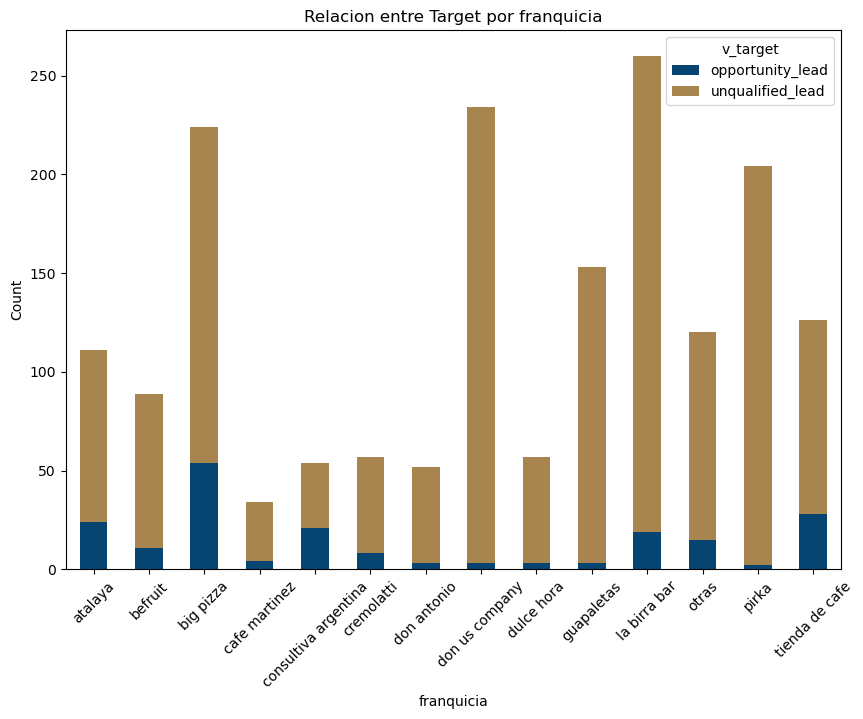

In [29]:
table = pd.crosstab(df['franquicia'], df['v_target'])
# Crear gráfico de barras apilado
table.plot(kind='bar', stacked=True, figsize=(10,7), color=colors)
plt.title('Relacion entre Target por franquicia')
plt.xlabel('franquicia')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [30]:
fig = go.Figure()
zonas_agrupadas = df.groupby(['v_target', 'zone']).size().reset_index(name='conteo')
# Mapear cada categoría única a un color
unique_targets = zonas_agrupadas['v_target'].unique()
color_dict = {target: colors[i % len(colors)] for i, target in enumerate(unique_targets)}
fig = go.Figure()
for elead in unique_targets:
    zonas_elead = zonas_agrupadas[zonas_agrupadas['v_target'] == elead]
    fig.add_trace(go.Bar(x=zonas_elead['zone'], y=zonas_elead['conteo'], name=str(elead), 
                         marker_color=color_dict[elead]))
# Diseño del gráfico
fig.update_layout(barmode='stack', title='Relación entre Target y Zone',
                  xaxis_title='Segmento de zone', yaxis_title='Cantidad de leeds')
fig.show()


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">🧠 Step 5 Model Definition</p>

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:110%; text-align:left">
    
* Utilizare un modelo de catboost y otro de random forest debido a la adaptación a las columnas categoricas y numericas, ademas aplicare la tecnica de sobremuestreo **SMOTE** para evitar desequilibrios de clases. 
    
* Es importante notar que el **90% de los datos son "unqualified_lead"**, lo cual puede sesgar al modelo y aun asi proporcionar una gran "precision" a pesar de ser ineficaz. 
    
* **Considerando que las oportunidades "opportunity_lead" no abundan, para tener exito sera impresindible no producir producir falsos negativos o falsos "unqualified_lead"**


In [31]:
df.iloc[102:108] 

,v_target,formularios enviados,visitas a la pagina,interacciones varias,aperturas de correo,franquicia,inversion,zone,source
282,opportunity_lead,1.0,1.0,2.0,2.0,big pizza,low,buenos aires,referencias
288,unqualified_lead,1.0,1.0,0.0,0.0,don antonio,low,sin valor,redes sociales de pago
291,unqualified_lead,1.0,1.0,3.0,1.0,cafe martinez,high,zonas menos recurrentes,redes sociales de pago
294,unqualified_lead,1.0,1.0,0.0,0.0,pirka,med,sin valor,redes sociales de pago
297,unqualified_lead,1.0,1.0,4.0,1.0,la birra bar,veryhigh,buenos aires,búsqueda de pago
300,unqualified_lead,0.0,0.0,0.0,0.0,guapaletas,med,zonas menos recurrentes,fuentes sin conexión


In [32]:
#Prepro
data = df
X = data.drop("v_target", axis=1)
y = data["v_target"]
numeric_features = ['formularios enviados', 'visitas a la pagina', 'interacciones varias' , 'aperturas de correo']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_features = ['franquicia', 'inversion', 'zone', 'source']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:100%; text-align:left">

* **Catboost Model**

In [33]:
# CatBoost 
clf1 = make_imb_pipeline(preprocessor, SMOTE(random_state=42), CatBoostClassifier(verbose=0))
params_catboost = {
    'catboostclassifier__iterations': randint(100, 500),
    'catboostclassifier__depth': randint(1, 10),
    'catboostclassifier__learning_rate': uniform(0.01, 0.3),
    'catboostclassifier__l2_leaf_reg': uniform(2, 30)
}
search_catboost = RandomizedSearchCV(clf1, param_distributions=params_catboost, n_iter=10, cv=3, verbose=0, random_state=42, n_jobs=-1)
search_catboost.fit(X_train, y_train)
y_pred_catboost = search_catboost.predict(X_test)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
* 📝 Predicciones y métricas 


In [34]:
print("Predicciones del modelo CatBoost")
print(classification_report(y_test, y_pred_catboost))
hl_c = hamming_loss(y_test, y_pred_catboost)
acc_c = accuracy_score(y_test, y_pred_catboost)
print(f"Hamming Loss:{hl_c}")
print(f"Accuracy: {acc_c}")



Predicciones del modelo CatBoost
                  precision    recall  f1-score   support

opportunity_lead       0.70      0.64      0.67        33
unqualified_lead       0.96      0.97      0.97       322

        accuracy                           0.94       355
       macro avg       0.83      0.80      0.82       355
    weighted avg       0.94      0.94      0.94       355

Hamming Loss:0.059154929577464786
Accuracy: 0.9408450704225352


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:103%; text-align:left">

* **RandomForest Model**

In [35]:
# Random Forest
clf2 = make_imb_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier())
params_rf = {
    'randomforestclassifier__n_estimators': randint(100, 500),
    'randomforestclassifier__max_depth': randint(1, 50),
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 5)
}
search_rf = RandomizedSearchCV(clf2, param_distributions=params_rf, n_iter=10, cv=3, verbose=0, random_state=42, n_jobs=-1)
search_rf.fit(X_train, y_train)
y_pred_rf = search_rf.predict(X_test)


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:108%; text-align:left">
* 📝Predicciones y métricas 

In [36]:
# Predicciones y métricas 
print("\nPredicciones del modelo RandomForest")
print(classification_report(y_test, y_pred_rf))
hl = hamming_loss(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
print(f"Hamming Loss:{hl}")
print(f"Accuracy: {acc}")


Predicciones del modelo RandomForest
                  precision    recall  f1-score   support

opportunity_lead       0.59      0.61      0.60        33
unqualified_lead       0.96      0.96      0.96       322

        accuracy                           0.92       355
       macro avg       0.77      0.78      0.78       355
    weighted avg       0.92      0.92      0.92       355

Hamming Loss:0.07605633802816901
Accuracy: 0.923943661971831


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📈 Step 6: Training and Validation Models</p>


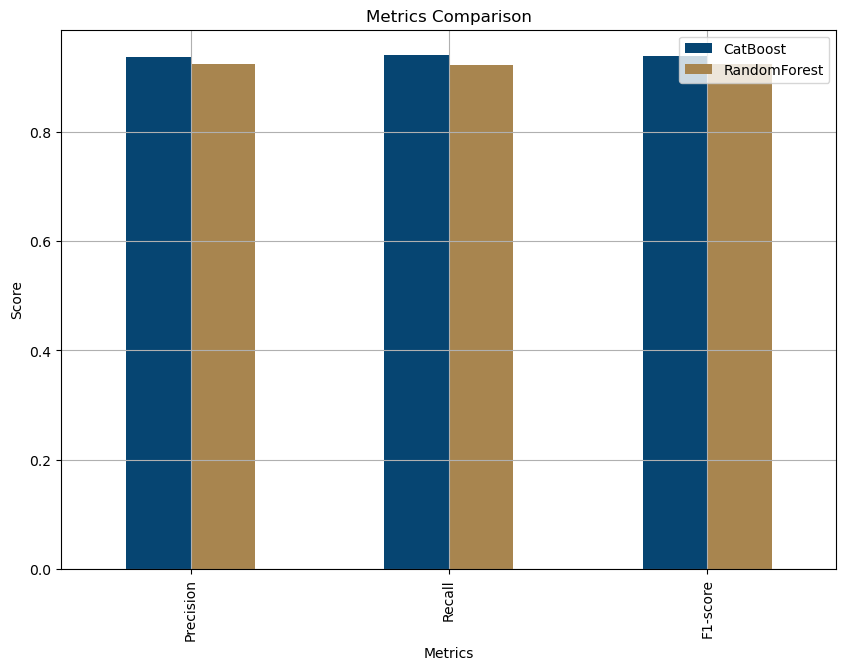

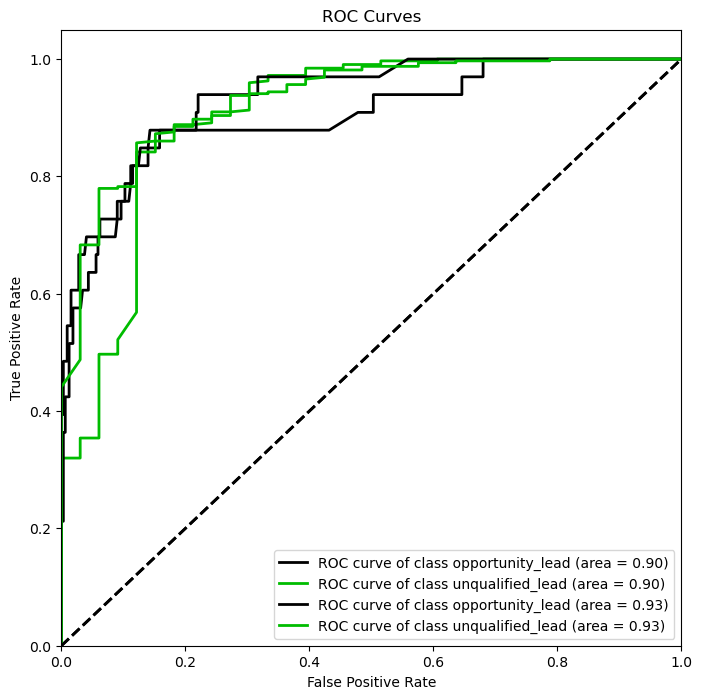

In [37]:

# Precision, recall y F1-score
prec_rec_f1_catboost = precision_recall_fscore_support(y_test, y_pred_catboost, average='weighted')
prec_rec_f1_rf = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')
# Crear df para visualización
df_metrics = pd.DataFrame({
    'Metrics': ['Precision', 'Recall', 'F1-score'],
    'CatBoost': [prec_rec_f1_catboost[0], prec_rec_f1_catboost[1], prec_rec_f1_catboost[2]],
    'RandomForest': [prec_rec_f1_rf[0], prec_rec_f1_rf[1], prec_rec_f1_rf[2]]
})
# Generar gráfico de barras para comparación
df_metrics.plot(x='Metrics', y=['CatBoost', 'RandomForest'], kind='bar', color=colors, figsize=(10, 7))
plt.title('Metrics Comparison')
plt.ylabel('Score')
plt.grid(True)
plt.show()
# Generar la curva ROC
fig, ax = plt.subplots(figsize=(8, 8))
y_probas_catboost = search_catboost.predict_proba(X_test)
y_probas_rf = search_rf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas_catboost, plot_macro=False, plot_micro=False, ax=ax)
skplt.metrics.plot_roc(y_test, y_probas_rf, plot_macro=False, plot_micro=False, ax=ax)
plt.title('ROC Curves')
plt.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:106%; text-align:left">

* Como es de suponer, el modelo presenta fallas en la clase minoritaria "opportunity_lead", a su vez la más relevante, **Considerando que las oportunidades no abundan, para tener exito sera impresindible no producir producir falsos negativos o "unqualified_lead.** 

* Por este motivo, definiremos **umbrales** mas altos en terminos probabilisticos para que el modelos nos proporcione un "unqualified_lead". Nuevamente, en busqueda de optimizar al maximo nuestro proceso y tiempo invertido pero generando el menor impacto posible en las oportunidades perdidas.
    
   

In [38]:
# Ajustar y probar el nuevo umbral de clasificación
umbral = 0.83 

In [39]:
# Para el modelo CatBoost
y_pred_prob_catboost = search_catboost.predict_proba(X_test)[:, 1]
y_pred_adj_catboost = np.where(y_pred_prob_catboost > umbral, "unqualified_lead", "opportunity_lead")

# Para el modelo RandomForest
y_pred_prob_rf = search_rf.predict_proba(X_test)[:, 1]
y_pred_adj_rf = np.where(y_pred_prob_rf > umbral, "unqualified_lead", "opportunity_lead")

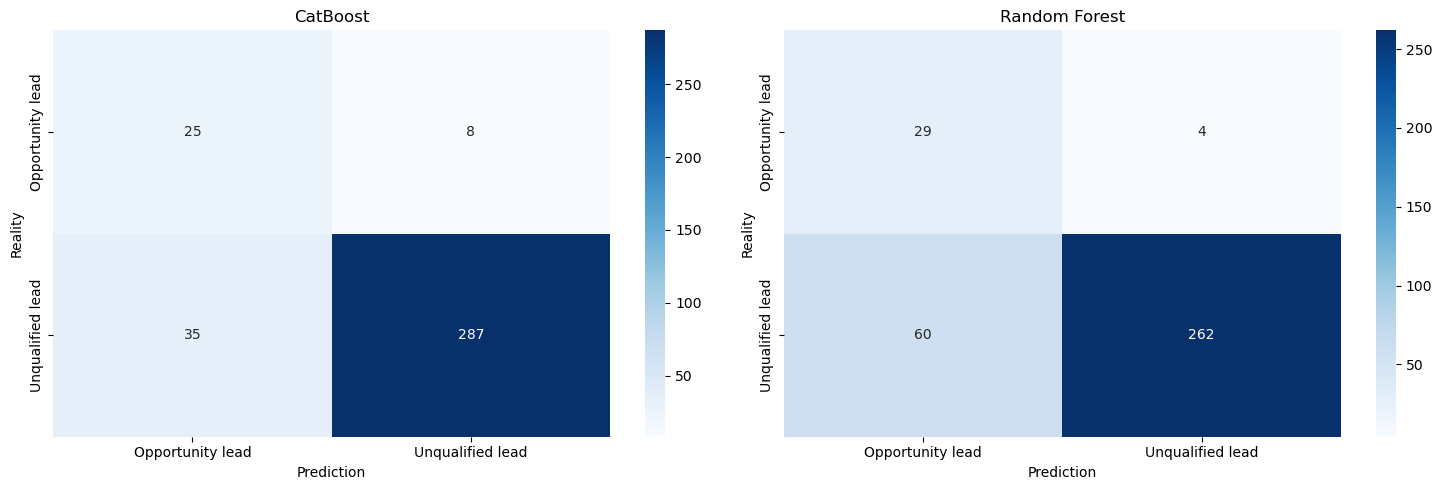

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar las matrices de confusión
cm_catboost = confusion_matrix(y_test, y_pred_adj_catboost)
cm_rf = confusion_matrix(y_test, y_pred_adj_rf)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Usar los nombres de las categorías en lugar de 0 y 1
categories = ['Opportunity lead', 'Unqualified lead']

sns.heatmap(cm_catboost, annot=True, fmt=".0f", ax=axes[0], cmap=plt.cm.Blues, xticklabels=categories, yticklabels=categories)
axes[0].set_title('CatBoost')
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Reality')

sns.heatmap(cm_rf, annot=True, fmt=".0f", ax=axes[1], cmap=plt.cm.Blues, xticklabels=categories, yticklabels=categories)
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Reality')

plt.tight_layout()
plt.show()


In [41]:
print("Reporte de Clasificación (CatBoost) Actualizado; Umbral 83%:")
print(classification_report(y_test, y_pred_adj_catboost))
hl_catboost = hamming_loss(y_test, y_pred_adj_catboost)
acc_catboost = accuracy_score(y_test, y_pred_adj_catboost)
print(f"\nHamming Loss (CatBoost):{hl_catboost}")
print(f"Accuracy (CatBoost): {acc_catboost}\n")

print("\n\nReporte de Clasificación (Random Forest) Actualizado; Umbral 83%:")
print(classification_report(y_test, y_pred_adj_rf))
hl_rf = hamming_loss(y_test, y_pred_adj_rf)
acc_rf = accuracy_score(y_test, y_pred_adj_rf)
print(f"\nHamming Loss (Random Forest):{hl_rf}")
print(f"Accuracy (Random Forest): {acc_rf}\n")


Reporte de Clasificación (CatBoost) Actualizado; Umbral 83%:
                  precision    recall  f1-score   support

opportunity_lead       0.42      0.76      0.54        33
unqualified_lead       0.97      0.89      0.93       322

        accuracy                           0.88       355
       macro avg       0.69      0.82      0.73       355
    weighted avg       0.92      0.88      0.89       355


Hamming Loss (CatBoost):0.12112676056338029
Accuracy (CatBoost): 0.8788732394366198



Reporte de Clasificación (Random Forest) Actualizado; Umbral 83%:
                  precision    recall  f1-score   support

opportunity_lead       0.33      0.88      0.48        33
unqualified_lead       0.98      0.81      0.89       322

        accuracy                           0.82       355
       macro avg       0.66      0.85      0.68       355
    weighted avg       0.92      0.82      0.85       355


Hamming Loss (Random Forest):0.18028169014084508
Accuracy (Random Forest): 0.81971

In [42]:
# Para el modelo CatBoost
y_pred_prob_catboost = search_catboost.predict_proba(X_test)
proba_df_catboost = pd.DataFrame(y_pred_prob_catboost, columns=search_catboost.best_estimator_.named_steps['catboostclassifier'].classes_)
proba_df_catboost['Prediccion'] = y_pred_adj_catboost
proba_df_catboost['Resultado?'] = proba_df_catboost['Prediccion'] == y_test.values
print("Breve muestra de Probabilidades y resultados Finales (CatBoost):")
print(proba_df_catboost.head(3))
# Para el modelo RandomForest
y_pred_prob_rf = search_rf.predict_proba(X_test)
proba_df_rf = pd.DataFrame(y_pred_prob_rf, columns=search_rf.best_estimator_.named_steps['randomforestclassifier'].classes_)
proba_df_rf['Prediccion'] = y_pred_adj_rf
proba_df_rf['Resultado?'] = proba_df_rf['Prediccion'] == y_test.values
print("\n\nBreve muestra de Probabilidades y resultados Finales (Random Forest):")
print(proba_df_rf.head(3))


Breve muestra de Probabilidades y resultados Finales (CatBoost):
   opportunity_lead  unqualified_lead        Prediccion  Resultado?
0          0.004453          0.995547  unqualified_lead        True
1          0.075334          0.924666  unqualified_lead       False
2          0.008071          0.991929  unqualified_lead        True


Breve muestra de Probabilidades y resultados Finales (Random Forest):
   opportunity_lead  unqualified_lead        Prediccion  Resultado?
0          0.064983          0.935017  unqualified_lead        True
1          0.459155          0.540845  opportunity_lead        True
2          0.072602          0.927398  unqualified_lead        True


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#05041B; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #FFB800">📈 Step 7: Conclusion y resultado</p>



In [43]:
# Obtener verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos de las matrices de confusión
tp_catboost, fn_catboost, fp_catboost, tn_catboost = cm_catboost.ravel()
tp_rf, fn_rf, fp_rf, tn_rf = cm_rf.ravel()
# Crear un DataFrame con estos valores para cada modelo
dfg = pd.DataFrame({
    'Predijo Calificado y resulto ser cierto (Optimizamos Atención)': [tp_catboost, tp_rf],
    'Predijo un mal lead y resulto ser cierto: (Ganacia de tiempo)': [tn_catboost, tn_rf],
    'Predijo Calificado y resulto ser falso (Perdida de tiempo)': [fp_catboost, fp_rf],
    'Predijo un mal lead y resulto ser falso (Costo de oportunidad)': [fn_catboost, fn_rf]
}, index=['CatBoost', 'Random Forest'])
# Transponer el DataFrame para que las métricas sean las columnas y los modelos sean las filas
dfg = dfg.T


In [44]:
# Crear un objeto de figura
fig = go.Figure()
# Ejemplo de cómo utilizar los colores en el gráfico de barras apiladas
for i, metric in enumerate(dfg.columns):
    fig.add_trace(go.Bar(
        y=dfg.index,
        x=dfg[metric],
        name=metric,
        marker_color=colors[i % len(colors)],  # Utilizar el color que corresponde a cada modelo
        orientation='h'
    ))
# Agregar título y nombres de ejes
fig.update_layout(
    title_text='Traducido a Resultados',
    xaxis_title='Count',
    yaxis_title='',
    barmode='stack'
)
# Mostrar el gráfico
fig.show()


<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:113%; text-align:left">
    
* Finalmente, resginando precision reducimos al maximo los falsos "negativos" o falsos "unqualified_lead" especialmente con el modelo Random Forest.

* Este modelo fue creado inicialmente con un conjunto de 430 leads para optimizar mi tiempo invertido en mi rol como consultor. Con el tiempo, la entrada de nuevos leads y el uso de nuevas tecnicas lo fueron optimizando hasta el dia de hoy.

<div style="border-radius:13px; border:#FFB800 solid; padding: 15px; background-color: #FAFFFF; font-size:100%; text-align:left">
